In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
class RBF:
    #初始化学习率、学习步数
    def __init__(self, learning_rate=0.002, step_num=10001, hidden_size=10):
        self.learning_rate=learning_rate
        self.step_num=step_num
        self.hidden_size=hidden_size
    
    # 使用 k-means 获取聚类中心、标准差
    def getC_S(self, x, class_num):
        estimator=KMeans(n_clusters=class_num, max_iter=10000) #构造聚类器
        estimator.fit(x) # 聚类
        c=estimator.cluster_centers_  # 聚类中心
        n=len(c)
        s=0;
        # 计算标准差
        for i in range(n):
            j=i+1
            while j<n:
                t=np.sum((c[i]-c[j])**2)
                s=max(s,t)
                j=j+1
        s=np.sqrt(s)/np.sqrt(2*n)
        return c,s
    
    # 高斯核函数(c为中心，s为标准差)
    def kernel(self,x,c,s):
        x1=tf.tile(x,[1,self.hidden_size]) # 将x水平复制 hidden次
        x2=tf.reshape(x1,[-1,self.hidden_size,self.feature])
        dist=tf.reduce_sum((x2-c)**2,2)
        return tf.exp(-dist/(2*s**2))
    
    # 训练RBF神经网络
    def train(self,x,y):
        self.feature=np.shape(x)[1] #输入值的特征数
        self.c,self.s=self.getC_S(x,self.hidden_size) #获取聚类中心、标准差
        
        x_=tf.placeholder(tf.float32,[None,self.feature]) #定义placeholder
        y_=tf.placeholder(tf.float32,[None,1]) #定义placeholder
        
        #定义径向基层
        z=self.kernel(x_,self.c,self.s)  
    
        #定义输出层
        w=tf.Variable(tf.random_normal([self.hidden_size,1]))
        b=tf.Variable(tf.zeros([1]))
        yf=tf.matmul(z,w)+b
        
        loss=tf.reduce_mean(tf.square(y_-yf)) #二次代价函数
        optimizer=tf.train.AdamOptimizer(self.learning_rate) #Adam优化器     
        train=optimizer.minimize(loss) #最小化代价函数
        init=tf.global_variables_initializer() #变量初始化
    
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(self.step_num):
                sess.run(train,feed_dict={x_:x,y_:y})
                if epoch>0 and epoch%500==0:
                    mse=sess.run(loss,feed_dict={x_:x,y_:y})
                    print(epoch,mse)
            self.w,self.b=sess.run([w,b],feed_dict={x_:x,y_:y})
        
    def kernel2(self,x,c,s): #预测时使用
        x1=np.tile(x,[1,self.hidden_size]) #将x水平复制 hidden次
        x2=np.reshape(x1,[-1,self.hidden_size,self.feature])
        dist=np.sum((x2-c)**2,2)
        return np.exp(-dist/(2*s**2))
    
    def predict(self,x):
        z=self.kernel2(x,self.c,self.s)
        pre=np.matmul(z,self.w)+self.b
        return pre

500 20.55486
1000 15.067047
1500 12.88822
2000 11.188057
2500 9.747671
3000 8.525929
3500 7.552801
4000 6.844568
4500 6.3734536
5000 6.074965
5500 5.8707504
6000 5.695168
6500 5.511029
7000 5.306238
7500 5.0815
8000 4.842098
8500 4.5947876
9000 4.346432
9500 4.103135
10000 3.8697803
10500 3.6498764
11000 3.4455888
11500 3.2578523
12000 3.086581
12500 2.9309525
13000 2.7897115
13500 2.6615467
14000 2.5453486
14500 2.4403288
15000 2.3459816
15500 2.2619543
16000 2.1879354
16500 2.1235983
17000 2.0685751
17500 2.0224414
18000 1.9847078
18500 1.9547949
19000 1.9320219
19500 1.9155825
20000 1.9045306


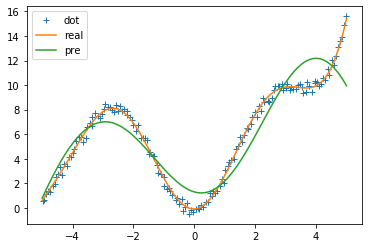

In [4]:
#待逼近的函数
def fun(x):
    return x*x+2*x*np.sin(x)-np.exp(-x)/10
 
#生成样本
def generate_samples():
    n=150 #样本点个数
    wideX=0.03 #横轴噪声的宽度
    wideY=0.5 #纵轴噪声宽度
    t=np.linspace(-5,5,n).reshape(-1,1) #横轴理想值
    u=fun(t) #纵轴理想值
    noisyX=np.random.uniform(-wideX,wideX,n).reshape(n,-1) #横轴噪声
    noisyY=np.random.uniform(-wideY,wideY,n).reshape(n,-1) #纵轴噪声
    x=t+noisyX #横轴实际值
    y=u+noisyY #纵轴实际值 
    return t,u,x,y
 
t,u,x,y=generate_samples()
rbf=RBF(0.003,20001,4) #学习率
rbf.train(x,y)
pre=rbf.predict(t)
plt.plot(x,y,'+')
plt.plot(t,u)
plt.plot(t,pre)
plt.legend(['dot','real','pre'],loc='upper left')

In [6]:
import numpy as np
import tensorflow as tf
 
class RBF:
    #初始化学习率、学习步数
    def __init__(self,learning_rate=0.002,step_num=10001,hidden_size=10):
        self.learning_rate=learning_rate
        self.step_num=step_num
        self.hidden_size=hidden_size
    
    #高斯核函数(c为中心，s为标准差)
    def kernel(self,x,c,s): #训练时使用
        x1=tf.tile(x,[1,self.hidden_size]) #将x水平复制 hidden次
        x2=tf.reshape(x1,[-1,self.hidden_size,self.feature])
        dist=tf.reduce_sum((x2-c)**2,2)
        return tf.exp(-dist/(2*s**2))
    
    #训练RBF神经网络
    def train(self,x,y):
        self.feature=np.shape(x)[1] #输入值的特征数
        x_=tf.placeholder(tf.float32,[None,self.feature]) #定义placeholder
        y_=tf.placeholder(tf.float32,[None,1]) #定义placeholder
        
        #定义径向基层
        c=tf.Variable(tf.random_normal([self.hidden_size,self.feature]))
        s=tf.Variable(tf.random_normal([self.hidden_size]))
        z=self.kernel(x_,c,s)
    
        #定义输出层
        w=tf.Variable(tf.random_normal([self.hidden_size,1]))
        b=tf.Variable(tf.zeros([1]))
        yf=tf.matmul(z,w)+b
        
        loss=tf.reduce_mean(tf.square(y_-yf))#二次代价函数
        optimizer=tf.train.AdamOptimizer(self.learning_rate) #Adam优化器
        train=optimizer.minimize(loss) #最小化代价函数
        init=tf.global_variables_initializer() #变量初始化
    
        with tf.Session() as sess:
            sess.run(init)
            for epoch in range(self.step_num):
                sess.run(train,feed_dict={x_:x,y_:y})
                if epoch>0 and epoch%500==0:
                    mse=sess.run(loss,feed_dict={x_:x,y_:y})
                    print(epoch,mse)
            self.c,self.s,self.w,self.b=sess.run([c,s,w,b],feed_dict={x_:x,y_:y})
        
    def kernel2(self,x,c,s): #预测时使用
        x1=np.tile(x,[1,self.hidden_size]) #将x水平复制 hidden次
        x2=np.reshape(x1,[-1,self.hidden_size,self.feature])
        dist=np.sum((x2-c)**2,2)
        return np.exp(-dist/(2*s**2))
    
    def predict(self,x):
        z=self.kernel2(x,self.c,self.s)
        pre=np.matmul(z,self.w)+self.b
        return pre

W1025 06:38:54.132792 11772 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


500 10.676139
1000 2.8575768
1500 1.3231313
2000 0.83032686
2500 0.6555413
3000 0.5939547
3500 0.5622466
4000 0.5379378
4500 0.5146274
5000 0.48764637
5500 0.440826
6000 0.19231708
6500 0.1658689
7000 0.1473806
7500 0.1328122
8000 0.12150473
8500 0.112841174
9000 0.106268354
9500 0.101315446
10000 0.097596094
10500 0.094803795
11000 0.0927014
11500 0.09110697
12000 0.08988586
12500 0.088936806
13000 0.0881879
13500 0.08758087
14000 0.08709391
14500 0.08666331
15000 0.08630785
15500 0.0859994
16000 0.085732505
16500 0.08549868
17000 0.085293405
17500 0.085112326
18000 0.08495188
18500 0.0848094
19000 0.08468331
19500 0.08457001
20000 0.08446951


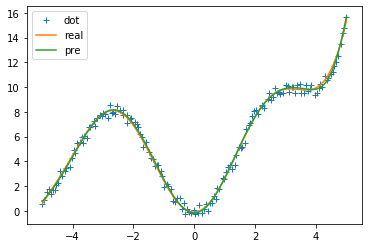

In [7]:
#待逼近的函数
def fun(x):
    return x*x+2*x*np.sin(x)-np.exp(-x)/10
 
#生成样本
def generate_samples():
    n=150 #样本点个数
    wideX=0.03 #横轴噪声的宽度
    wideY=0.5 #纵轴噪声宽度
    t=np.linspace(-5,5,n).reshape(-1,1) #横轴理想值
    u=fun(t) #纵轴理想值
    noisyX=np.random.uniform(-wideX,wideX,n).reshape(n,-1) #横轴噪声
    noisyY=np.random.uniform(-wideY,wideY,n).reshape(n,-1) #纵轴噪声
    x=t+noisyX #横轴实际值
    y=u+noisyY #纵轴实际值
    return t,u,x,y
    
t,u,x,y=generate_samples()
rbf=RBF(0.003,20001,4) #学习率
rbf.train(x,y)
pre=rbf.predict(t)
plt.plot(x,y,'+')
plt.plot(t,u)
plt.plot(t,pre)
plt.legend(['dot','real','pre'],loc='upper left')